<a href="https://colab.research.google.com/github/smit-patel-m/SummerInternship/blob/main/PUF_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
import os
import re
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
import os
from google.colab import drive

if not os.path.exists("/content/db1"):
    drive.mount('/content/drive')
    !unzip "/content/drive/MyDrive/Summer Internship/ML Attack.zip" -d "/content/db1"
else:
    print("Folder '/content/db1' already exists. Skipping unzip.")


Folder '/content/db1' already exists. Skipping unzip.


# Load the Excel files into pandas DataFrames

In [ ]:
# Load the Excel files into pandas DataFrames

response_delay_path = "/content/db1/ML Attack/Responce_Delay_2us.xlsx"
challenge_path = "/content/db1/ML Attack/Challenge.xlsx"
response_delay_sheet_names = pd.ExcelFile(response_delay_path).sheet_names
response_delay_df = pd.read_excel(response_delay_path, sheet_name=0,header=None)

challenge_df = pd.read_excel(challenge_path,header=None)


In [ ]:
# Display the first few rows of each DataFrame to verify
print("Selected Sheet Name:", response_delay_sheet_names)

print("Response Delay DataFrame:")
display(response_delay_df.head())

print("\nChallenge DataFrame:")
display(challenge_df.head())

Selected Sheet Name: ['FD_MODE_1', 'VD_MODE_1', 'FD_MODE_2', 'VD_MODE_2', 'FD_MODE_3', 'VD_MODE_3', 'FD_MODE_4', 'VD_MODE_4', 'FD_MODE_5', 'VD_MODE_5', 'FD_MODE_6', 'VD_MODE_6', 'FD_MODE_7', 'VD_MODE_7', 'FD_MODE_8', 'VD_MODE_8']
Response Delay DataFrame:


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0,1,1,1,1,0,1,1,1,1,...,1,1,1,0,0,0,0,0,0,0
1,1,0,1,1,1,0,0,0,0,1,...,0,1,1,0,0,0,1,0,0,1
2,1,1,0,0,1,1,0,0,0,0,...,1,1,0,1,1,0,1,1,1,1
3,1,1,1,0,1,1,0,0,1,1,...,1,1,0,0,0,1,1,0,1,1
4,0,1,0,0,0,1,0,1,1,1,...,1,0,1,1,0,0,0,1,0,0



Challenge DataFrame:


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0,1,0,0,0,0,0,1,1,1,...,1,0,1,1,0,0,0,1,1,1
1,0,1,1,0,0,1,0,1,1,1,...,0,1,1,0,1,0,0,1,0,0
2,0,0,1,0,1,0,0,1,0,0,...,0,0,1,1,0,1,1,0,1,1
3,0,0,0,1,1,0,0,0,1,0,...,1,1,0,0,1,0,0,0,1,1
4,1,1,1,0,1,0,0,0,0,1,...,1,0,0,0,0,1,0,0,1,0


In [ ]:
# Convert to NumPy
X = challenge_df.values.astype(np.float32)     # shape: (N, 32)
Y = response_delay_df.values.astype(np.float32)  # shape: (N, 32)

In [ ]:
X

array([[0., 1., 0., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 1.],
       ...,
       [0., 1., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [ ]:
Y

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [0., 1., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 1., 0., ..., 1., 1., 1.]], dtype=float32)

In [ ]:
#X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss


# Define the model
class MultiOutputNN(nn.Module):
    def __init__(self):
        super(MultiOutputNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

    def forward(self, x):
        return self.model(x)

# Data preprocessing
def preprocess(X, Y):
   # X = X * 0.98 + 0.01
    X_tensor = torch.tensor(X, dtype=torch.float32)
    Y_tensor = torch.tensor(Y, dtype=torch.float32)
    return TensorDataset(X_tensor, Y_tensor)

# Dataset splitting (train 70%, test 20%, val 10%)
def split_dataset(dataset):
    total_size = len(dataset)
    train_size = int(0.7 * total_size)
    test_size = int(0.2 * total_size)
    val_size = total_size - train_size - test_size
    return random_split(dataset, [train_size, test_size, val_size])

# Validation
def validate_model(model: nn.Module, val_loader: DataLoader):
    model.eval()
    sigmoid = nn.Sigmoid()
    total_bits, total_errors = 0, 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            probs = sigmoid(logits)
            preds = (probs > 0.5).float()
            total_errors += (preds != yb).sum().item()
            total_bits += yb.numel()

    accuracy = (1 - total_errors / total_bits) * 100
    return accuracy


# Testing
def test_model(model: nn.Module, test_loader: DataLoader):
    model.eval()
    sigmoid = nn.Sigmoid()
    total_bits, total_errors = 0, 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            probs = sigmoid(logits)
            preds = (probs > 0.5).float()
            total_errors += (preds != yb).sum().item()
            total_bits += yb.numel()

    accuracy = (1 - total_errors / total_bits) * 100
    print(f"\n✅ Final Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Training loop (with per-epoch validation)
def train_model(model, train_loader, val_loader, epochs=500, early_stop=1e-5):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    sigmoid = nn.Sigmoid()

    prev_loss = float('inf')
    history = []

    for epoch in range(epochs):
        model.train()
        train_loss, bit_errors, total_bits = 0, 0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            preds = (sigmoid(out) > 0.5).float()
            bit_errors += (preds != yb).sum().item()
            train_loss += loss.item()
            total_bits += yb.numel()

        train_acc = (1 - bit_errors / total_bits) * 100
        val_acc = validate_model(model, val_loader)
        scheduler.step(train_loss)

        history.append((epoch + 1, train_loss, train_acc, val_acc))
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if abs(prev_loss - train_loss) < early_stop:
            print(f"Early stopping at epoch {epoch+1}: Δloss < {early_stop}")
            break

        prev_loss = train_loss

    return history

# Plot Accuracy
def plot_accuracy(history):
    epochs, train_accs, val_accs = [], [], []
    for epoch, _, train_acc, val_acc in history:
        epochs.append(epoch)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accs, label="Train Accuracy", marker='o')
    plt.plot(epochs, val_accs, label="Validation Accuracy", marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Epoch vs Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [ ]:

dataset = preprocess(X, Y)
train_set, test_set, val_set = split_dataset(dataset)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

model = MultiOutputNN().to(device)



In [ ]:
history = train_model(model, train_loader, val_loader)

test_model(model, test_loader)

Epoch 1/500 | Train Loss: 37.9114 | Train Acc: 54.36% | Val Acc: 55.02%
Epoch 2/500 | Train Loss: 37.8256 | Train Acc: 55.20% | Val Acc: 55.02%
Epoch 3/500 | Train Loss: 37.8144 | Train Acc: 55.20% | Val Acc: 55.02%
Epoch 4/500 | Train Loss: 37.7975 | Train Acc: 55.19% | Val Acc: 55.02%
Epoch 5/500 | Train Loss: 37.7627 | Train Acc: 55.22% | Val Acc: 55.00%
Epoch 6/500 | Train Loss: 37.7215 | Train Acc: 55.23% | Val Acc: 54.95%
Epoch 7/500 | Train Loss: 37.6757 | Train Acc: 55.37% | Val Acc: 54.82%
Epoch 8/500 | Train Loss: 37.6023 | Train Acc: 55.53% | Val Acc: 54.50%
Epoch 9/500 | Train Loss: 37.5013 | Train Acc: 55.87% | Val Acc: 54.24%
Epoch 10/500 | Train Loss: 37.3946 | Train Acc: 56.33% | Val Acc: 53.33%
Epoch 11/500 | Train Loss: 37.2675 | Train Acc: 56.93% | Val Acc: 53.26%
Epoch 12/500 | Train Loss: 37.1384 | Train Acc: 57.44% | Val Acc: 53.09%
Epoch 13/500 | Train Loss: 36.9373 | Train Acc: 58.11% | Val Acc: 52.52%
Epoch 14/500 | Train Loss: 36.7633 | Train Acc: 58.69% | Val

50.03124999999999

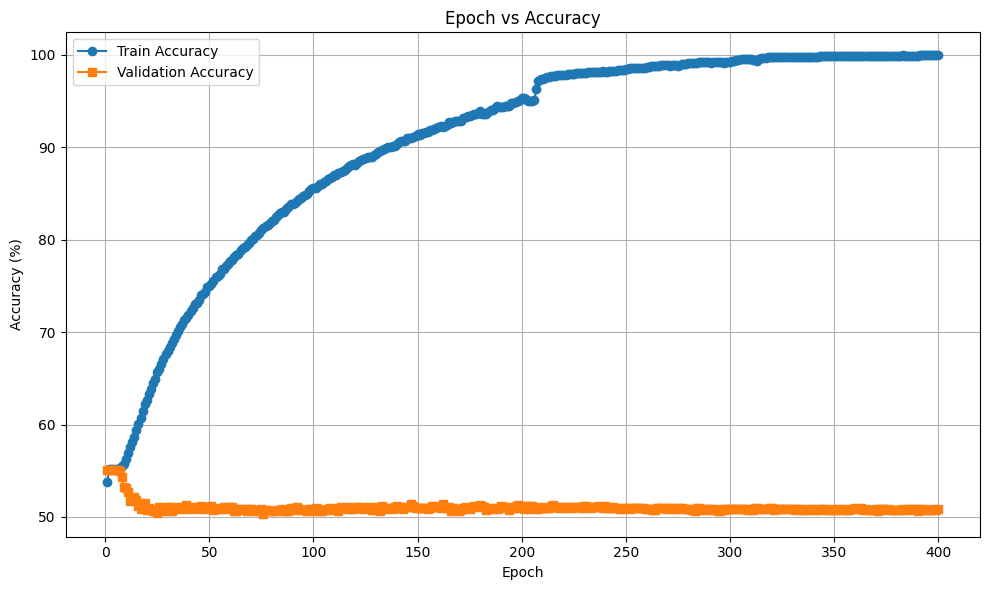

In [ ]:
plot_accuracy(history)



In [ ]:


def get_next_model_version(base_path="/content/drive/MyDrive/SummerIntern/Puf Models", prefix="puf_Neural_Network"):
    os.makedirs(base_path, exist_ok=True)
    existing = [f for f in os.listdir(base_path) if f.startswith(prefix)]
    versions = [int(re.findall(r'V(\d+)', name)[0]) for name in existing if re.search(r'V\d+', name)]
    next_version = max(versions) + 1 if versions else 1
    model_folder = f"{prefix}_V{next_version}"
    return os.path.join(base_path, model_folder)

def save_model(model, path, history=None):
    os.makedirs(path, exist_ok=True)

    # Save model weights
    model_path = os.path.join(path, "model.pth")
    torch.save(model.state_dict(), model_path)
    print(f"✅ Model saved at: {model_path}")

    # Save training history
    if history is not None:
        history_df = pd.DataFrame(history, columns=["Epoch", "Train Loss", "Train Accuracy", "Val Accuracy"])
        excel_path = os.path.join(path, "training_history.xlsx")
        history_df.to_excel(excel_path, index=False)
        print(f"📊 Training history saved at: {excel_path}")


def load_model(path, model_class):
    model = model_class()
    model.load_state_dict(torch.load(os.path.join(path, "model.pth"), map_location=device))
    model.to(device)
    model.eval()
    print(f"✅ Model loaded from: {os.path.join(path, 'model.pth')}")
    return model



In [ ]:
# Save
save_path = get_next_model_version()
save_model(model, save_path,history)


✅ Model saved at: /content/drive/MyDrive/SummerIntern/Puf Models/puf_Neural_Network_V3/model.pth
📊 Training history saved at: /content/drive/MyDrive/SummerIntern/Puf Models/puf_Neural_Network_V3/training_history.xlsx


In [ ]:
save_path

'/content/drive/MyDrive/SummerIntern/Puf Models/puf_Neural_Network_V3'

In [ ]:
# Load and test

path = "/content/drive/MyDrive/SummerIntern/Puf Models/puf_Neural_Network_V3"
loaded_model = load_model(path, MultiOutputNN)
test_model(loaded_model, test_loader)

✅ Model loaded from: /content/drive/MyDrive/SummerIntern/Puf Models/puf_Neural_Network_V3/model.pth

✅ Final Test Accuracy: 50.03%


50.03124999999999

In [ ]:



def predict_batch_32bit(model: nn.Module, input_array: np.ndarray, threshold: float = 0.5) -> list:
    assert input_array.ndim == 2 and input_array.shape[1] == 32, "Input must be of shape [N, 32]"

    model.eval()
    normalized_input = input_array

    with torch.no_grad():
        input_tensor = torch.tensor(normalized_input, dtype=torch.float32).to(device)

        logits = model(input_tensor)
        probs = torch.sigmoid(logits)
        predictions = (probs > threshold).int().tolist()  # List of [0,1] lists

    return predictions

def evaluate_predictions(y_true: np.ndarray, y_pred: np.ndarray):
    assert y_true.shape == y_pred.shape, "Shape mismatch between true and predicted labels"

    metrics = {}

    # Bitwise metrics (macro = average over each bit)
    metrics["bitwise_accuracy"] = accuracy_score(y_true.flatten(), y_pred.flatten())
    metrics["macro_precision"] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics["macro_recall"] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    metrics["macro_f1"] = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # Hamming loss (fraction of incorrect bits)
    metrics["hamming_loss"] = hamming_loss(y_true, y_pred)

    # Exact match (all 32 bits correct)
    exact_matches = np.all(y_true == y_pred, axis=1)
    metrics["exact_match_ratio"] = np.mean(exact_matches)

    return metrics


In [ ]:
X = challenge_df.values.astype(np.float32)  # shape [N, 32]

# Predict all rows
predictions = predict_batch_32bit(model, X)


predictions_np = np.array(predictions)

print("Predictions shape:", predictions_np.shape)
print("First prediction:", predictions[0])

Predictions shape: (5000, 32)
First prediction: [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]


In [ ]:

Y_true = Y.astype(np.int32)
X_input = X.astype(np.float32)
Y_pred = np.array(predict_batch_32bit(loaded_model, X_input))

metrics = evaluate_predictions(Y_true, Y_pred)


for name, value in metrics.items():
    print(f"{name}: {value:.4f}")


bitwise_accuracy: 0.8508
macro_precision: 0.8661
macro_recall: 0.8630
macro_f1: 0.8645
hamming_loss: 0.1492
exact_match_ratio: 0.6998
